In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from helper import ResidualBoostClassifier as RBC

# Unidad Energía,GWh,,,,,,,,, for sp_forecasting_test

# Data Cleaning

In [2]:
df = pd.read_csv('Input Data.csv')

# 2) Normalize the column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)

# 3) Parse your date
df['date'] = pd.to_datetime(df['row_labels'], errors='coerce')

df['reservoir_inflows_per'] = (
    pd.to_numeric(df['reservoir_inflows_per'].str.rstrip(' %'), errors='coerce')
    / 100
)


#  - remove commas and coerce every other numeric column
num_cols = [
    'electric_demand',
    'reservoir_inflows_gwh',
    'reservoir_gwh',
    'energy_dumping_gwh',
    'cere_copkwh',
    'spot_price_copkwh',
    'scarcity_price_copkwh',
    'thermo_transport_cost_copkwh',
    'thermo_supply_cost_copkwh'
]
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.replace(',', '', regex=False),
        errors='coerce'
    )

# 5) Drop the old “row_labels” and any exact duplicates
df = df.drop(columns=['row_labels']).drop_duplicates()

# 6) Sort by date
df = df.sort_values('date').reset_index(drop=True)



# SARIMAX

In [3]:
# assume df is your cleaned, indexed-by-date DataFrame
endog = df['spot_price_copkwh']
exog  = df[['reservoir_inflows_gwh','reservoir_gwh','reservoir_inflows_per']]

# split train/test
train_end = int(len(df)*0.8)
endog_train, endog_test = endog[:train_end], endog[train_end:]
exog_train, exog_test = exog[:train_end], exog[train_end:]



# fit SARIMAX(p,d,q)x(P,D,Q,12)
model = sm.tsa.SARIMAX(endog_train,
                       exog=exog_train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
res = model.fit(disp=False)

# forecast
pred = res.predict(start=endog_test.index[0], end=endog_test.index[-1], exog=exog_test)

print(endog_test.shape)
print(len(endog_test))
print('')
print(pred.shape)
print(len(pred))

print("SARIMAX RMSE:", root_mean_squared_error(endog_test, pred))

KeyboardInterrupt: 

NameError: name 'pred' is not defined

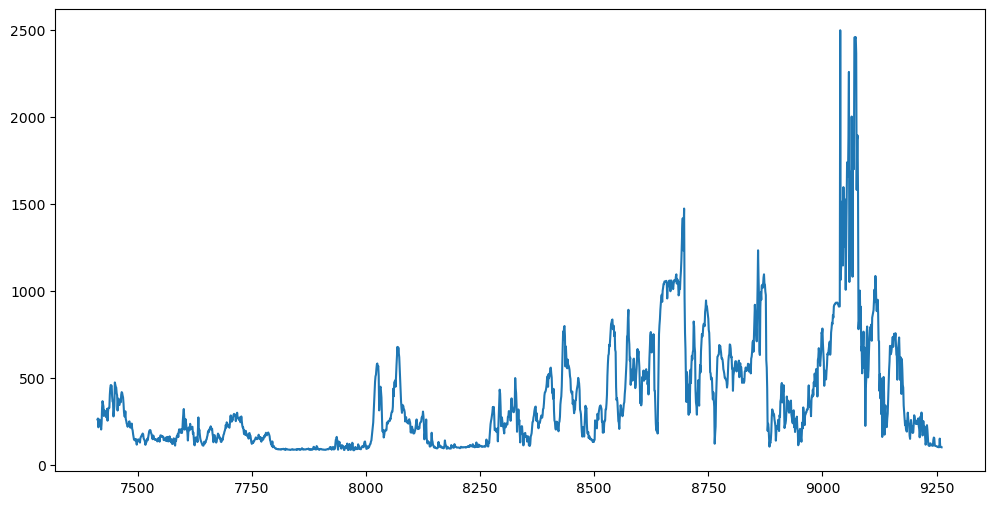

In [4]:
# if pred is an array, make it a Series with the same index as endog_test
# pred = pd.Series(pred, index=endog_test.index)

plt.figure(figsize=(12, 6))
plt.plot(endog_test.index, endog_test, label='Actual Spot Price')
plt.plot(endog_test.index, pred,      label='SARIMAX Prediction')
plt.legend()
plt.title('Actual vs. Predicted Spot Price (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()


# RANDOM FOREST

Test RMSE: 104.73


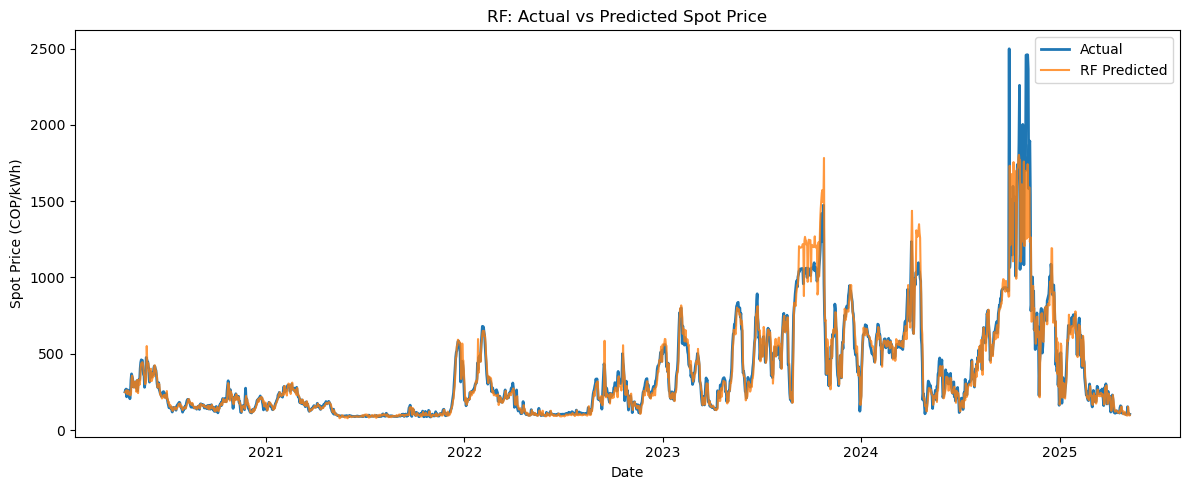

In [5]:
df['reservoir_gwh_lag1']        = df['reservoir_gwh'].shift(1)
df['reservoir_inflows_gwh_lag1']= df['reservoir_inflows_gwh'].shift(1)

# 1) create lag features for historic spot prices
for lag in [1, 3, 7]:
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)

# 2) drop rows with NaNs from those shifts
df_model = df.dropna(subset=[
    'reservoir_gwh',
    'reservoir_inflows_gwh',
    'spot_lag_1',
    'spot_lag_3',
    'spot_lag_7',
    'spot_price_copkwh'
]).reset_index(drop=True)

# 3) define X & y
feature_cols = [
    'reservoir_gwh',
    'reservoir_inflows_gwh',
    'spot_lag_1',
    'spot_lag_3',
    'spot_lag_7'
]
X = df_model[feature_cols]
y = df_model['spot_price_copkwh']

# 4) 80/20 time‐based split
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test   = df_model['date'].iloc[split_idx:]

# 5) train RF & eval
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")

# 6) plot actual vs. predicted
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred, label='RF Predicted', alpha=0.8)
plt.legend()
plt.title('RF: Actual vs Predicted Spot Price')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()


# XGBOOST and RF

RF 2025 Test RMSE: 63.65
XGB 2025 Test RMSE: 58.99


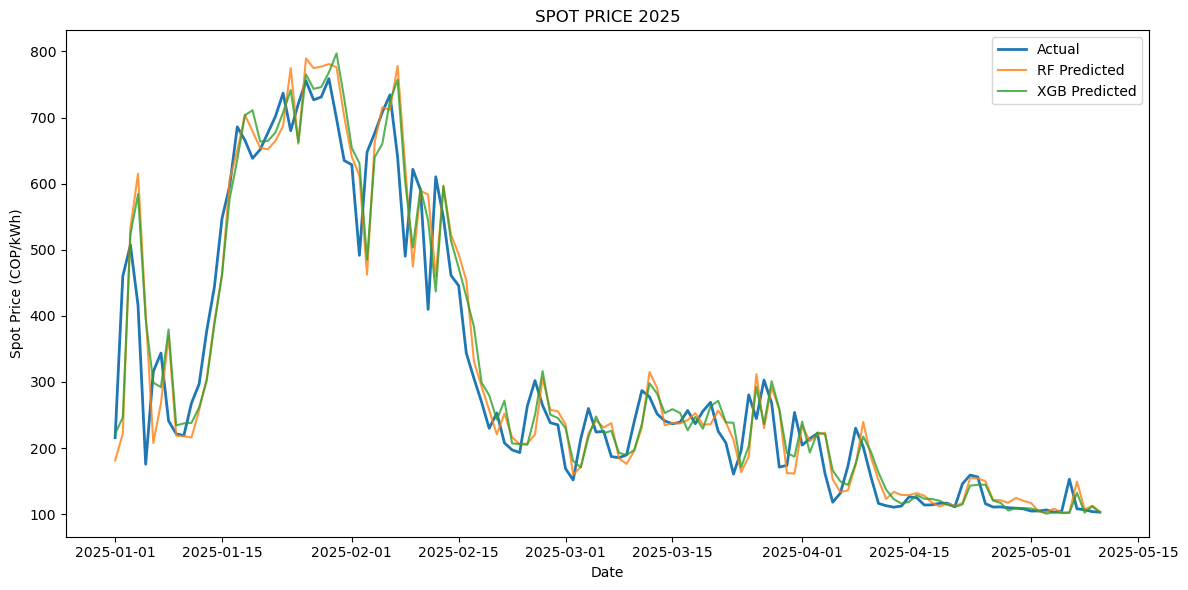

In [6]:
# 0) Make sure date is datetime
df_model['date'] = pd.to_datetime(df_model['date'])

# 1) Select your train / test years
train = df_model[df_model['date'].dt.year.between(2020, 2024)]
test  = df_model[df_model['date'].dt.year == 2025]

X_train = train[feature_cols]
y_train = train['spot_price_copkwh']
X_test  = test[feature_cols]
y_test  = test['spot_price_copkwh']
dates   = test['date']

# 2) Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
print(f"RF 2025 Test RMSE: {rmse_rf:.2f}")

# 3) XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"XGB 2025 Test RMSE: {rmse_xgb:.2f}")

# 4) Plot actual vs both predictions
plt.figure(figsize=(12,6))
plt.plot(dates, y_test, label='Actual', linewidth=2)
plt.plot(dates, y_pred_rf, label='RF Predicted', alpha=0.8)
plt.plot(dates, y_pred_xgb, label='XGB Predicted', alpha=0.8)
plt.legend()
plt.title('SPOT PRICE 2025')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

In [7]:
clf = RBC(
    base_reg    = RandomForestRegressor(n_estimators=100, random_state=42),
    residual_reg= XGBRegressor(n_estimators=100, random_state=42)
)

clf.fit(X_train, y_train)

# 2) Predict on your 2025 test set
y_pred = clf.predict(X_test)

# 3) Compute RMSE correctly
rmse = root_mean_squared_error(y_test, y_pred)
print(f"2025 Test RMSE (RBC): {rmse:.2f}")

2025 Test RMSE (RBC): 63.51


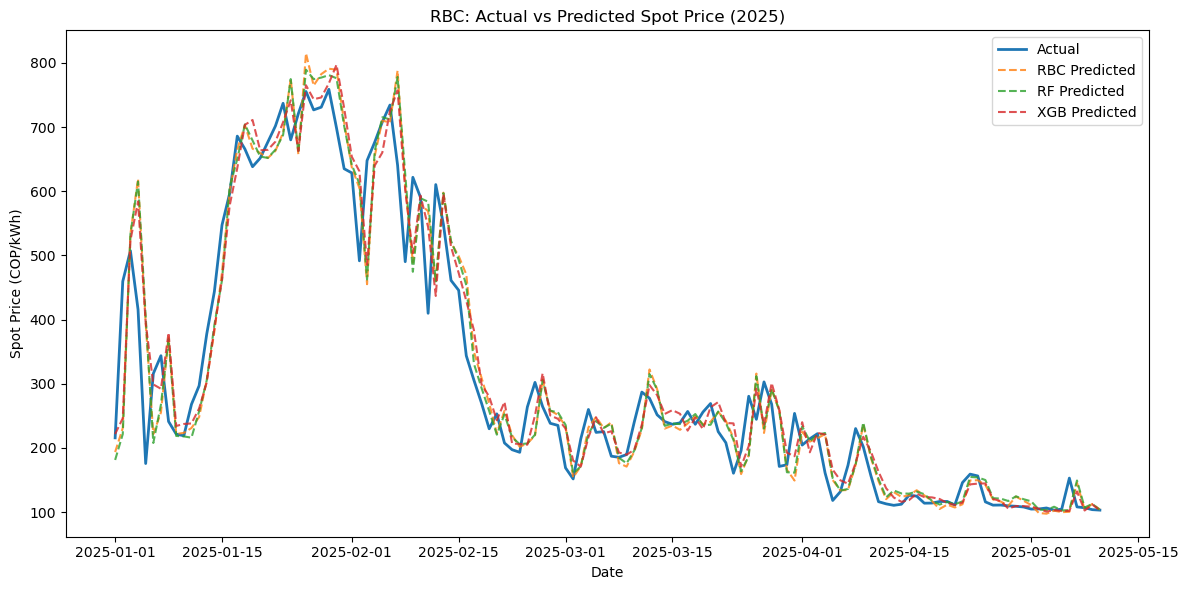

In [8]:
plt.figure(figsize=(12,6))
plt.plot(dates, y_test, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='RBC Predicted', alpha=0.8, linestyle='--')

plt.plot(dates, y_pred_rf, label='RF Predicted', alpha=0.8, linestyle='--')
plt.plot(dates, y_pred_xgb, label='XGB Predicted', alpha=0.8, linestyle='--')


plt.legend()
plt.title('RBC: Actual vs Predicted Spot Price (2025)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()

Maximum Error in COP/kWh: 241.85656743164063


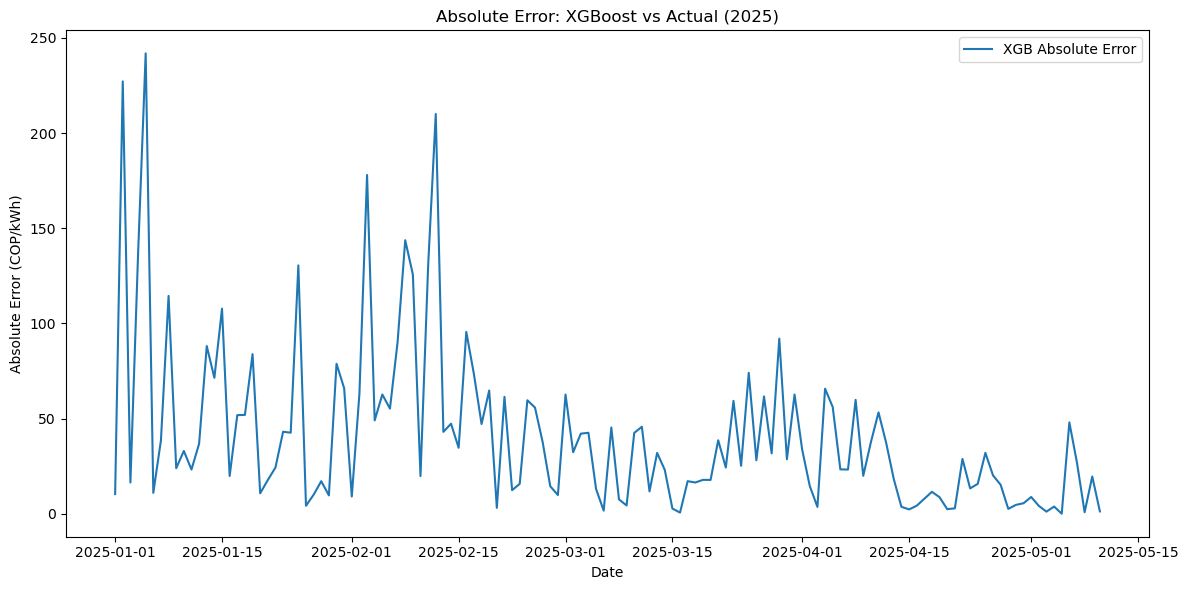

Maximum Perc Error: 137.62274889303933
Minimum Perc Error: 0.08242333502752991


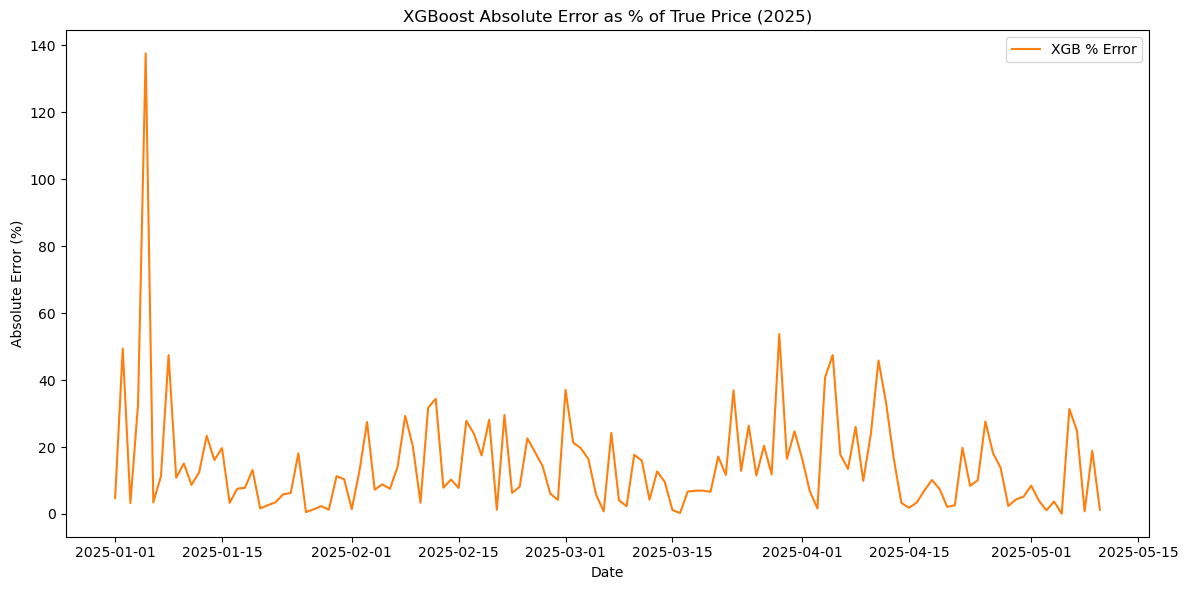

In [35]:
# 5) Compute absolute error for XGBoost
abs_error_xgb = np.abs(y_test - y_pred_xgb)
print(f'Maximum Error in COP/kWh: {max(abs_error_xgb)}')

# 6) Plot the absolute error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, abs_error_xgb, label='XGB Absolute Error')
plt.legend()
plt.title('Absolute Error: XGBoost vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (COP/kWh)')
plt.tight_layout()
plt.show()

# 7) Compute percent error
pct_error_xgb = abs_error_xgb / y_test * 100

print(f'Maximum Perc Error: {max(pct_error_xgb)}')
print(f'Minimum Perc Error: {min(pct_error_xgb)}')

# 8) Plot percent error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, pct_error_xgb, label='XGB % Error', color='tab:orange')
plt.legend()
plt.title('XGBoost Absolute Error as % of True Price (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (%)')
plt.tight_layout()
plt.show()

# Correlation Plots

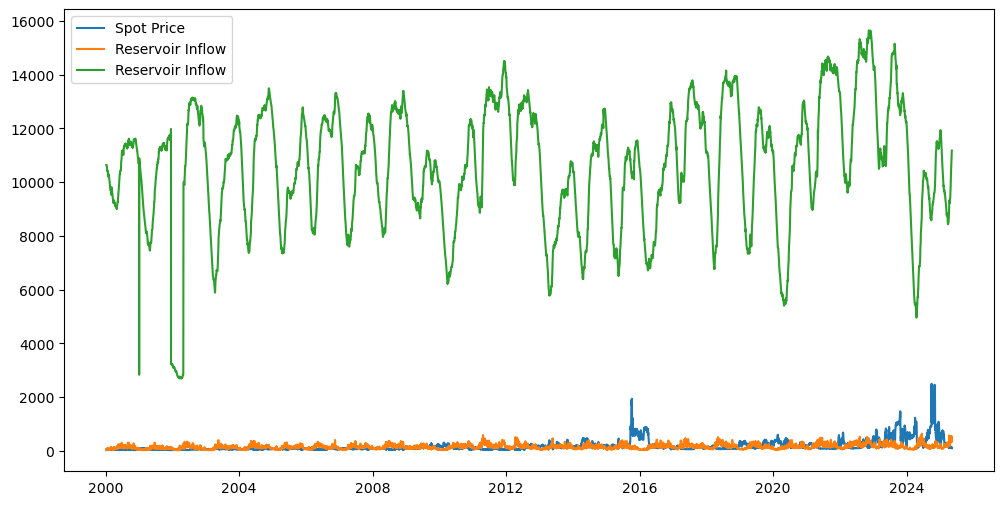

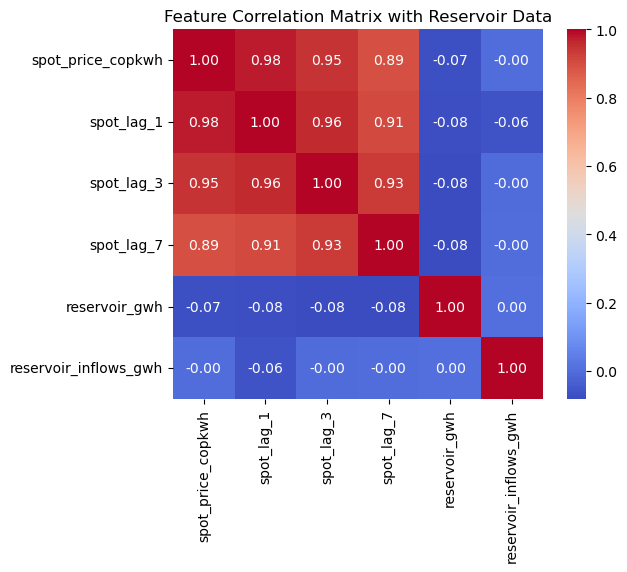

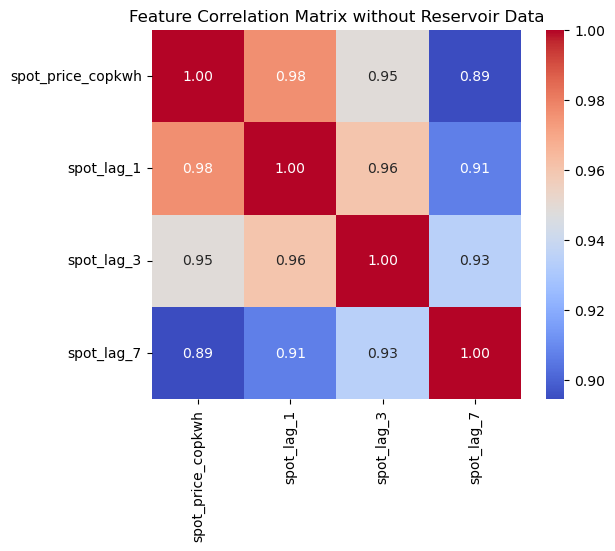

In [30]:
# 'electric_demand',
# 'reservoir_inflows_gwh',
# 'reservoir_gwh',
# 'energy_dumping_gwh',
# 'cere_copkwh',
# 'spot_price_copkwh',

# Plotting features against time and each other
plt.figure(figsize=(12, 6))
plt.plot(df_model['date'], np.array(df_model['spot_price_copkwh']), label='Spot Price')
plt.plot(df_model['date'], np.array(df_model['reservoir_inflows_gwh']), label = 'Reservoir Inflow')
plt.plot(df_model['date'], np.array(df_model['reservoir_gwh']), label = 'Reservoir Inflow')
plt.legend()
plt.show()

    
# Correlation matrices
corr_matrix = df[['spot_price_copkwh', 'spot_lag_1','spot_lag_3','spot_lag_7', 'reservoir_gwh','reservoir_inflows_gwh']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix with Reservoir Data")
plt.show()    

# Correlation matrices
corr_matrix = df[['spot_price_copkwh', 'spot_lag_1','spot_lag_3','spot_lag_7']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix without Reservoir Data")
plt.show()

# XGBOOST on only lags

XGB (lags-only) 2025 Test RMSE: 60.91


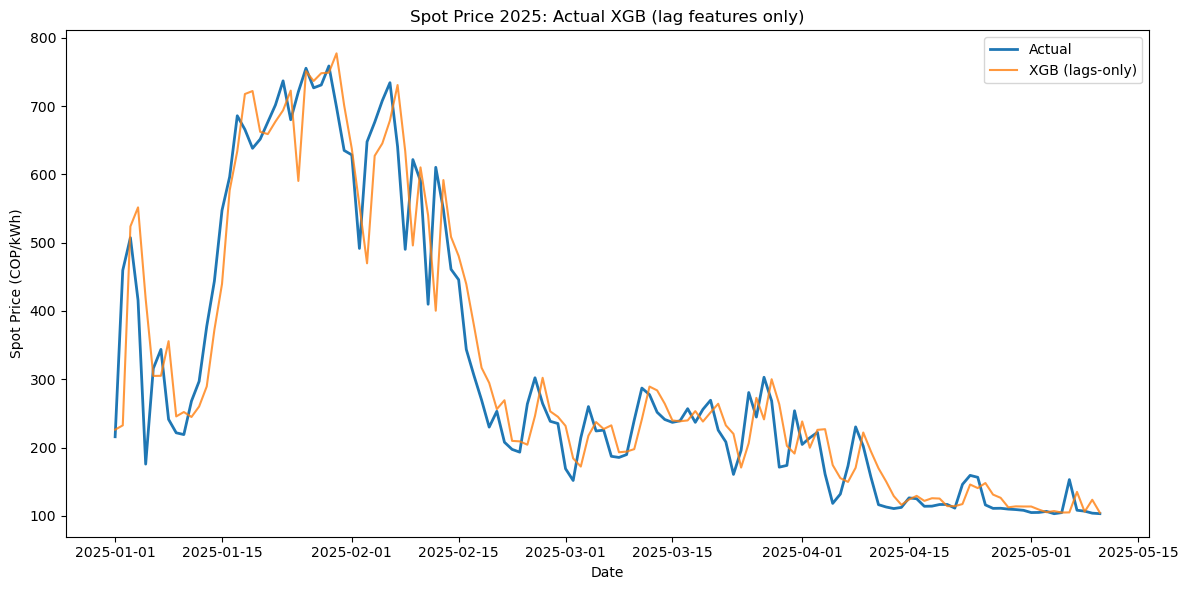

Maximum Error in COP/kWh: 241.85656743164063


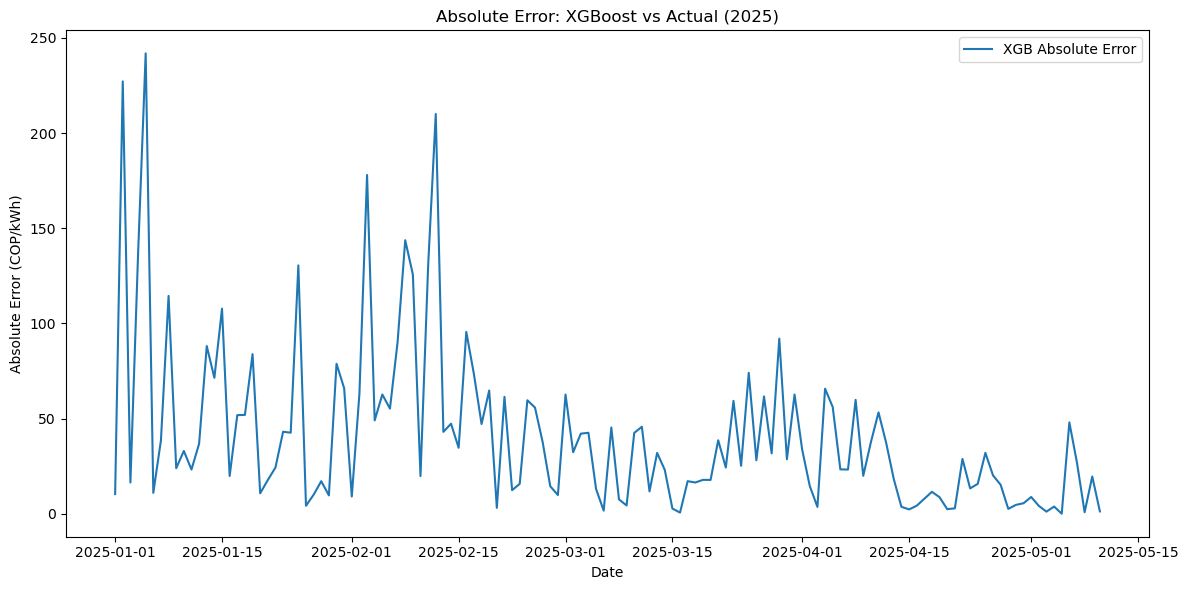

Maximum Perc Error: 137.62274889303933
Minimum Perc Error: 0.08242333502752991


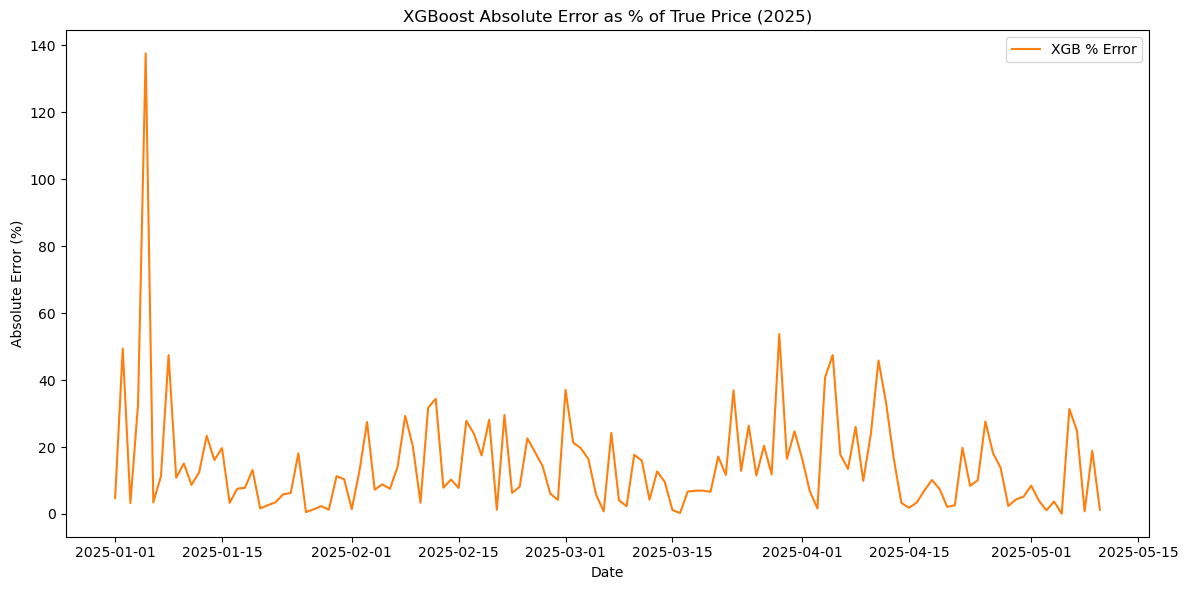

In [34]:
# define the **lag-only** feature set
lag_features = ['spot_lag_1', 'spot_lag_3', 'spot_lag_7']

# train/test split by year
train = df_model[df_model['date'].dt.year.between(2020, 2024)]
test  = df_model[df_model['date'].dt.year == 2025]

X_train_all = train[feature_cols]              # your original RF features
X_test_all  = test[feature_cols]
y_train     = train['spot_price_copkwh']
y_test      = test['spot_price_copkwh']
dates       = test['date']


# 3) XGBoost **only on lags**:
X_train_lags = train[lag_features]
X_test_lags  = test[lag_features]

xgb_lag = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_lag.fit(X_train_lags, y_train)
y_pred_xgb = xgb_lag.predict(X_test_lags)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"XGB (lags-only) 2025 Test RMSE: {rmse_xgb:.2f}")

# 4) Plot Actual vs RF vs XGB (lags-only)
plt.figure(figsize=(12,6))
plt.plot(dates,      y_test,        label='Actual',           linewidth=2)
plt.plot(dates,      y_pred_xgb,    label='XGB (lags-only)',  alpha=0.8)
plt.legend()
plt.title('Spot Price 2025: Actual XGB (lag features only)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()


# 5) Compute absolute error for XGBoost
abs_error_xgb = np.abs(y_test - y_pred_xgb)
print(f'Maximum Error in COP/kWh: {max(abs_error_xgb)}')

# 6) Plot the absolute error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, abs_error_xgb, label='XGB Absolute Error')
plt.legend()
plt.title('Absolute Error: XGBoost vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (COP/kWh)')
plt.tight_layout()
plt.show()

# 7) Compute percent error
pct_error_xgb = abs_error_xgb / y_test * 100

print(f'Maximum Perc Error: {max(pct_error_xgb)}')
print(f'Minimum Perc Error: {min(pct_error_xgb)}')

# 8) Plot percent error over time
plt.figure(figsize=(12, 6))
plt.plot(dates, pct_error_xgb, label='XGB % Error', color='tab:orange')
plt.legend()
plt.title('XGBoost Absolute Error as % of True Price (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (%)')
plt.tight_layout()
plt.show()

Although XGBoost is a great predictor, the percent error varies too much for me. A 140% error won't help anyone 